In [1]:
!pip install -U imbalanced-learn


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import compute_class_weight

In [3]:
plt.rcParams["figure.dpi"] = 120
plt.rcParams['savefig.dpi'] = 300

# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [4]:
df = pd.read_csv(
    'data/healthcare-dataset-stroke-data.csv',
    index_col="id"
)



print(df.shape)
df.info()

(5110, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [5]:
df.reset_index(drop=True, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
print(df['gender'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


# Handling missing values in `bmi` column

Usiamo il SimpleImputer di sklearn

In [7]:
print("Missing values before imputation:", df['bmi'].isnull().sum())

Missing values before imputation: 201


In [8]:
imputer = SimpleImputer(strategy='mean')

filename = 'model/imputer.sav'
pickle.dump(imputer, open(filename, 'wb'))

# Fit the imputer on the 'bmi' column
imputer.fit(df[['bmi']])

# Transform the 'bmi' column by replacing missing values with the mean
df['bmi'] = imputer.transform(df[['bmi']])

In [9]:
print("Missing values after imputation:", df['bmi'].isnull().sum())

Missing values after imputation: 0


In [10]:
print(df.select_dtypes(include=['object']))         # <- stampiamo il sottoinsieme del dataframe con tipo 'object'
print(df.select_dtypes(include=['object']).columns) # <- stampiamo solo i nomi delle colonne di tipo 'object'
categorical_cols = list(df.select_dtypes(include=['object']).columns)
print(categorical_cols)


      gender ever_married      work_type Residence_type   smoking_status
0       Male          Yes        Private          Urban  formerly smoked
1     Female          Yes  Self-employed          Rural     never smoked
2       Male          Yes        Private          Rural     never smoked
3     Female          Yes        Private          Urban           smokes
4     Female          Yes  Self-employed          Rural     never smoked
...      ...          ...            ...            ...              ...
5105  Female          Yes        Private          Urban     never smoked
5106  Female          Yes  Self-employed          Urban     never smoked
5107  Female          Yes  Self-employed          Rural     never smoked
5108    Male          Yes        Private          Rural  formerly smoked
5109  Female          Yes       Govt_job          Urban          Unknown

[5110 rows x 5 columns]
Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dty

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoded_cols = pd.DataFrame(
    encoder.fit_transform(df[categorical_cols]).toarray(), 
    columns=encoder.get_feature_names_out(categorical_cols)
)

filename = 'model/onehot_encoder.sav'
pickle.dump(encoder, open(filename, 'wb'))


encoded_cols

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df_encoded = pd.concat(
    [df, encoded_cols], 
    axis=1
)
df_encoded.drop(categorical_cols, axis=1, inplace=True)

df = df_encoded.copy()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Female                   5110 non-null   float64
 7   gender_Male                     5110 non-null   float64
 8   gender_Other                    5110 non-null   float64
 9   ever_married_No                 5110 non-null   float64
 10  ever_married_Yes                5110 non-null   float64
 11  work_type_Govt_job              5110 non-null   float64
 12  work_type_Never_worked          51

['age', 'avg_glucose_level', 'bmi']


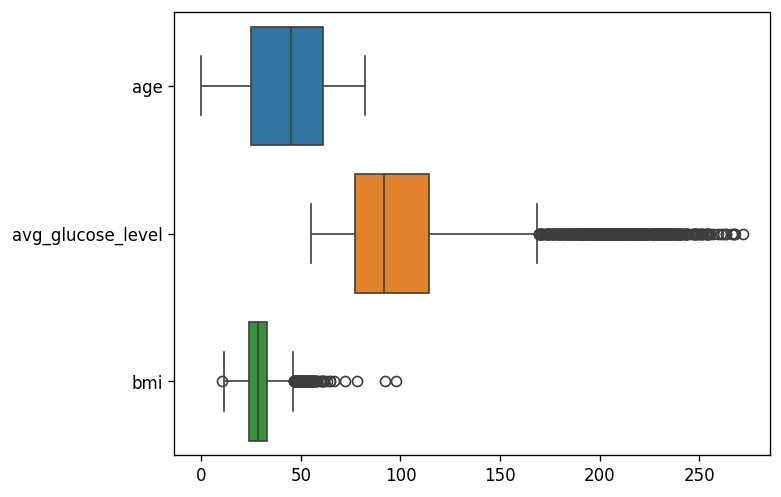

In [14]:
float_columns = ['age', 'avg_glucose_level', 'bmi']

print(float_columns)

sns.boxplot(data = df[float_columns], orient = "h")
plt.show()

In [15]:
scaler = StandardScaler()

# Fit and transform the selected numerical columns
df_encoded[float_columns] = scaler.fit_transform(df_encoded[float_columns])

filename = 'model/scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

# Print the updated DataFrame
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0,0,202.21,28.893237,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.500000,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0,171.23,34.400000,1,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1,0,174.12,24.000000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


['age', 'avg_glucose_level', 'bmi']


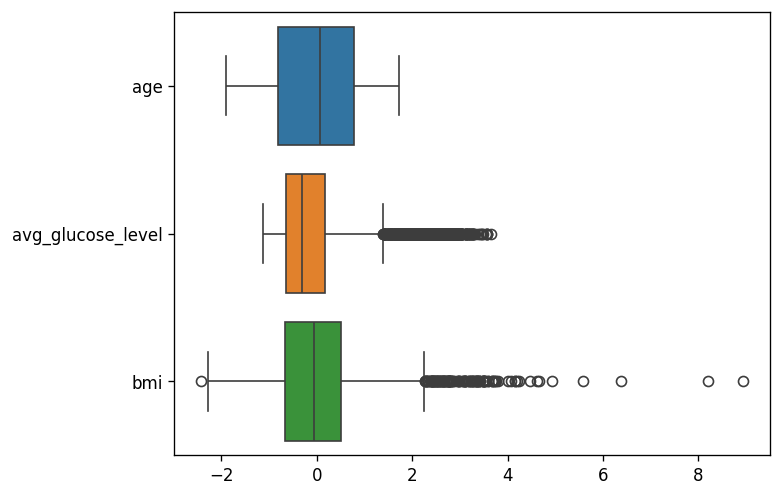

In [16]:
print(float_columns)

sns.boxplot(data = df_encoded[float_columns], orient = "h")
plt.show()

## Gestire gli outlier con IQR

Un approccio consiste nell'utilizzare percentili, come l'intervallo interquartile (IQR), per identificare i valori anomali. Le osservazioni che scendono al di sotto del quartile inferiore meno una certa soglia o al di sopra del quartile superiore più una certa soglia possono essere considerate valori anomali.



In [17]:
outlier_threshold = 1.5

for col in float_columns:
    # Calculate the IQR
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - outlier_threshold * IQR
    upper_bound = Q3 + outlier_threshold * IQR
    
    print(f"{col} -> {lower_bound}, {upper_bound}")
    
    # remove outliers
    df_encoded = df_encoded[(df_encoded[col] >= lower_bound) & (df_encoded[col] <= upper_bound)]


# Print the updated DataFrame
df_encoded.shape

age -> -3.194393101644997, 3.1743479772447083
avg_glucose_level -> -1.858917758723901, 1.3960035056466606
bmi -> -2.461034925572104, 2.163984745475581


(4383, 22)

['age', 'avg_glucose_level', 'bmi']


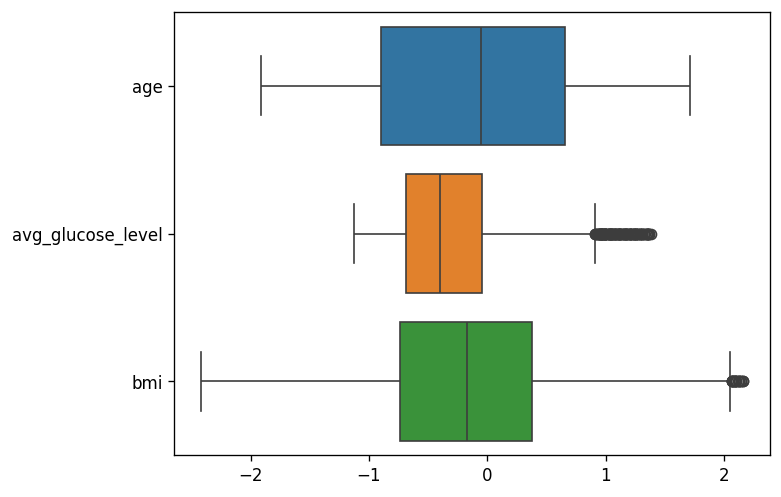

In [18]:
print(float_columns)

sns.boxplot(data = df_encoded[float_columns], orient = "h")
plt.show()

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='avg_glucose_level', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='avg_glucose_level'>,
        <Axes: xlabel='avg_glucose_level', ylabel='avg_glucose_level'>,
        <Axes: xlabel='bmi', ylabel='avg_glucose_level'>],
       [<Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='avg_glucose_level', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>]], dtype=object)

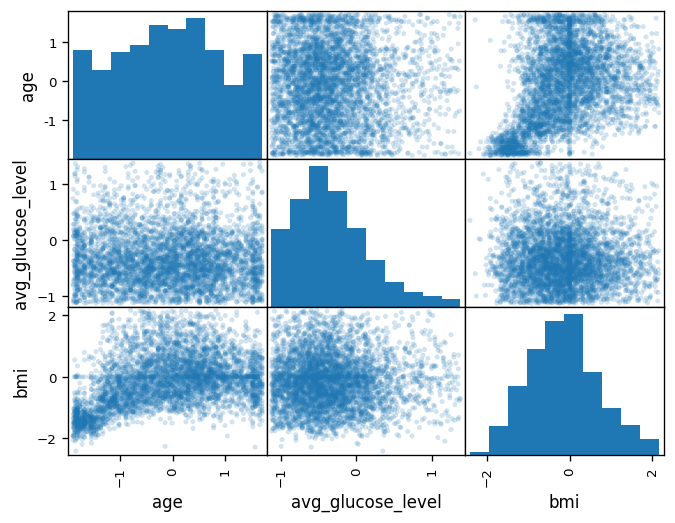

In [19]:
pd.plotting.scatter_matrix(df_encoded[float_columns], alpha=0.2)

stroke
0    4219
1     164
dtype: int64


<Axes: title={'center': 'Distribuzione'}, xlabel='stroke'>

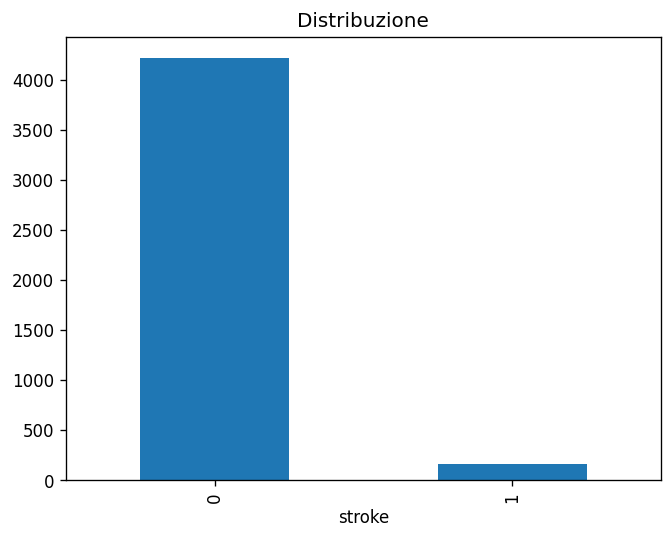

In [20]:
y_fieldname = "stroke"

print(df_encoded.pivot_table(index=y_fieldname, aggfunc="size"))
df_encoded.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, 
    df_encoded[y_fieldname], 
    stratify=df_encoded[y_fieldname], 
    random_state=42
)
X_train.drop([y_fieldname], axis=1)
X_test.drop([y_fieldname], axis=1)


print(X_train.shape)
print(X_test.shape)


(3287, 22)
(1096, 22)


<Axes: title={'center': 'Distribuzione'}, xlabel='stroke'>

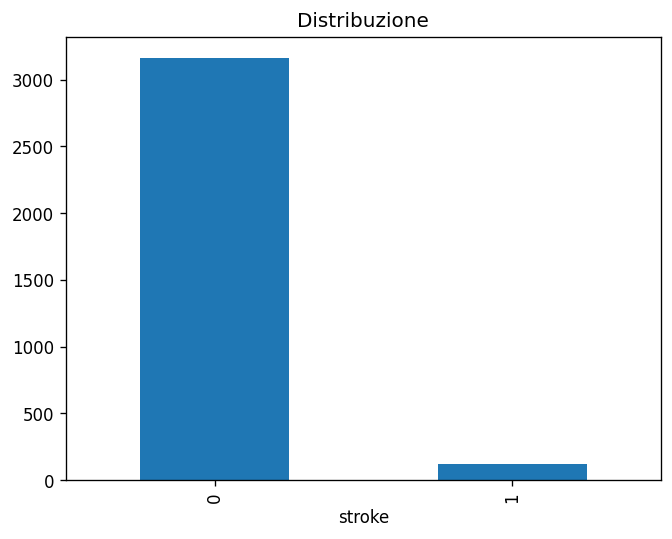

In [22]:
X_train.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

<Axes: title={'center': 'Distribuzione'}, xlabel='stroke'>

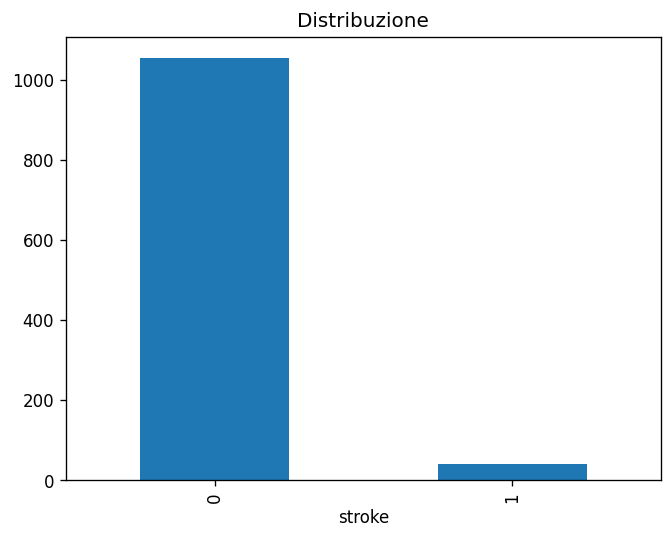

In [23]:
X_test.pivot_table(index=y_fieldname, aggfunc="size").plot(kind='bar', title="Distribuzione")

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

y_fieldname = "stroke"
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv', index_col="id")

# Reindicizzare il DataFrame
df.reset_index(drop=True, inplace=True)

# Suddivisione del dataset in set di train e test con stratificazione
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[y_fieldname]), 
    df[y_fieldname], 
    stratify=df[y_fieldname], 
    random_state=42
)

# Imputazione
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train[['bmi']])
X_train['bmi'] = imputer.transform(X_train[['bmi']])
X_test['bmi'] = imputer.transform(X_test[['bmi']])

# Salvataggio dell'imputer
filename = 'model/imputer.sav'
pickle.dump(imputer, open(filename, 'wb'))

# Codifica One-Hot
categorical_cols = list(X_train.select_dtypes(include=['object']).columns)
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_cols]).toarray(), 
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]).toarray(), 
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index
)

# Unire le colonne codificate ai DataFrame originali e rimuovere le colonne categoriali originali
X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded], axis=1)

# Salvataggio dell'encoder
filename = 'model/onehot_encoder.sav'
pickle.dump(encoder, open(filename, 'wb'))

# Standardizzazione
scaler = StandardScaler()
scaler.fit(X_train)

X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

# Salvataggio dello scaler
filename = 'model/scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

# Stampa delle dimensioni finali dei set
print(X_train.shape)
print(X_test.shape)


(3832, 21)
(1278, 21)


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # Dropout rate of 30%
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights dictionary:", class_weight_dict)


# Compile the model with AUC as a metric
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[AUC(name='auc')])

# Train the model
history = model.fit(
    X_train, y_train, epochs=10, batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1,
    # class_weight=class_weight_dict
)

# Predict on the test set and generate a confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype(int)  # Convert probabilities to binary outcomes



Class weights dictionary: {0: 0.5256515775034294, 1: 10.245989304812834}
Epoch 1/10


/Users/giumast/workspace/train-prey-deploy/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.4722 - loss: 0.9177 - val_auc: 0.3923 - val_loss: 0.8056
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - auc: 0.4711 - loss: 0.8311 - val_auc: 0.3944 - val_loss: 0.7257
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - auc: 0.4490 - loss: 0.7633 - val_auc: 0.4046 - val_loss: 0.6573
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - auc: 0.4043 - loss: 0.7016 - val_auc: 0.4230 - val_loss: 0.5993
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - auc: 0.4467 - loss: 0.6519 - val_auc: 0.4450 - val_loss: 0.5508
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - auc: 0.4833 - loss: 0.5960 - val_auc: 0.4668 - val_loss: 0.5115
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - auc: 0.4372 - loss: 0.5930 - val_auc: 0.4826 - val_loss: 0.4798
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - auc: 0.5163 - loss: 0.5439 - val_auc: 0.4927 - val_loss: 0.4524
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step

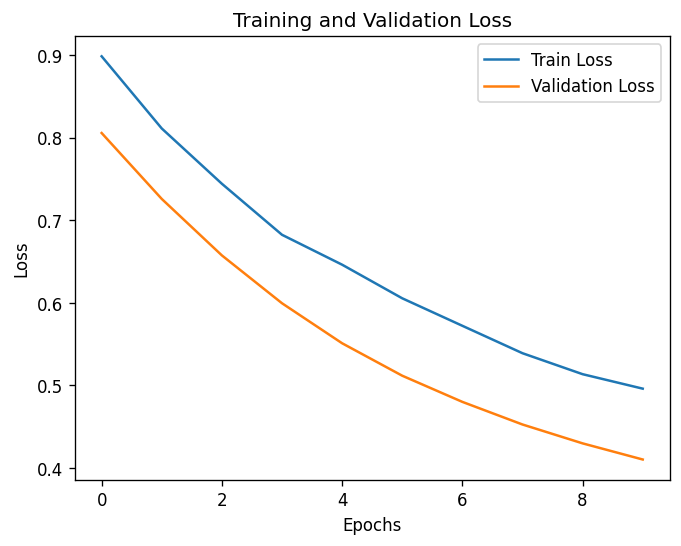

In [26]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

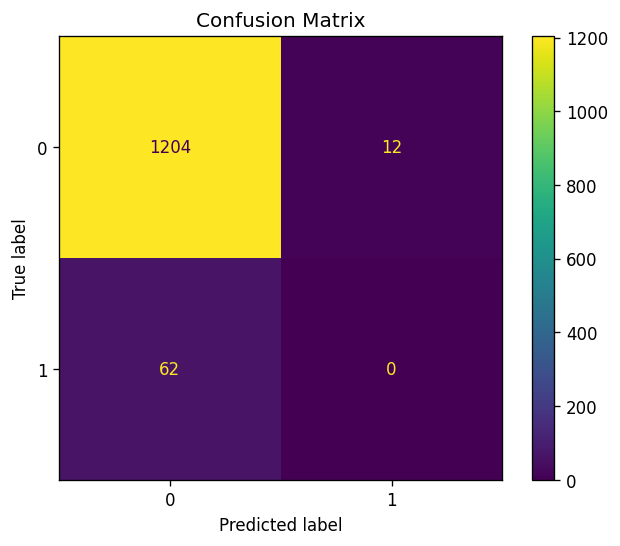

In [27]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

In [28]:
model.save("model/model.keras")

In [29]:
data = pd.read_csv('data/healthcare-dataset-stroke-data-encoded.csv')

In [30]:
data.columns

Index(['Unnamed: 0', 'age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi', 'stroke', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [31]:
for i in data.columns: 
    print(i)

Unnamed: 0
age
hypertension
heart_disease
avg_glucose_level
bmi
stroke
gender_Female
gender_Male
gender_Other
ever_married_No
ever_married_Yes
work_type_Govt_job
work_type_Never_worked
work_type_Private
work_type_Self-employed
work_type_children
Residence_type_Rural
Residence_type_Urban
smoking_status_Unknown
smoking_status_formerly smoked
smoking_status_never smoked
smoking_status_smokes


In [32]:
tensor = np.array([[54, 1, 0, 0, 1, 1, 135.4, 28, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
print(tensor.shape)

(1, 21)


In [33]:
prediction = (model.predict(tensor) > 0.4).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [34]:
prediction

array([[0]])